## The name of the DB is NYCAsthmasDismissals
## *within the SQLquery* group the data by zipcode.

In [1]:
import ast
# note this is python2 compatible only. the pykriging code is also python2 only
import urllib2
import urllib
from cStringIO import StringIO
import json
import geopandas as gpd
import pandas as pd
import os as os
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
import shapely
from __future__ import print_function
import numpy as np
import pylab as pl
%pylab inline

PUIDATA = os.getenv('PUIDATA')

SQL_SOURCE = 'https://fb55.carto.com:443/api/v2/sql' 

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

Populating the interactive namespace from numpy and matplotlib


In [2]:
# fill in the query details in facilityQuery: 
# within a single query collect AND GROUP the data by zipcode
facilityQuery = '''
select count(cartodb_id) as count, zipcodes
from fb55.nycasthmasdismissals
GROUP BY zipcodes
'''
facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData   = json.loads(facilityStream.read())
facilityData
facilities     = pd.DataFrame.from_dict(facilityData['rows'])
facilities.head()

,count,zipcodes
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375


# Find a shape file with zipcode shapes for NYC, download it and open it with geopandas.
# Merge the dataframe with the facility dismissals (the file you got on Carto)  joining on the zipcode and  use the zipcode geometry centers to extract the x and y coordinates of the zipcode center.

In [3]:
!curl -O "https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson"
shapefile="nyc-zip-code-tabulation-areas-polygons.geojson"
os.system("mv " + shapefile + " " + os.getenv("PUIDATA"))
shapefile = PUIDATA +"/nyc-zip-code-tabulation-areas-polygons.geojson"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  591k  100  591k    0     0  1647k      0 --:--:-- --:--:-- --:--:-- 9701k


In [4]:
shapes = GeoDataFrame.from_file(shapefile)
shapes.rename(columns = {'postalCode': 'zipcodes'}, inplace=True)
shapes['zipcodes'] = shapes['zipcodes'].astype(int)
facilities['zipcodes'] = facilities['zipcodes'].astype(int)

In [5]:
merged = pd.merge(shapes, facilities, how='inner', on='zipcodes')
merged.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,zipcodes,count
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,926
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,6,Elmhurst,NY,36,4.265940e+07,33755.870988,Queens,POLYGON ((-73.88722098467157 40.72752618766134...,11373,405
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,8,Forest Hills,NY,36,5.558777e+07,36277.076839,Queens,"POLYGON ((-73.8562474640478 40.7367227854824, ...",11375,246
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,14,Jamaica,NY,36,6.017758e+07,33123.943672,Queens,POLYGON ((-73.80904031652176 40.71991162363268...,11432,293
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,19,Richmond Hill,NY,36,3.202513e+07,31854.377541,Queens,POLYGON ((-73.83714702640651 40.70795706458588...,11418,567


In [6]:
merged['centers']=shapes.geometry.centroid
merged.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,zipcodes,count,centers
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,926,POINT (-73.88357286802307 40.75166307169953)
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,6,Elmhurst,NY,36,4.265940e+07,33755.870988,Queens,POLYGON ((-73.88722098467157 40.72752618766134...,11373,405,POINT (-73.71160619542474 40.74537094501076)
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,8,Forest Hills,NY,36,5.558777e+07,36277.076839,Queens,"POLYGON ((-73.8562474640478 40.7367227854824, ...",11375,246,POINT (-73.70344982649 40.74873122436191)
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,14,Jamaica,NY,36,6.017758e+07,33123.943672,Queens,POLYGON ((-73.80904031652176 40.71991162363268...,11432,293,POINT (-73.72400273065516 40.73653495923434)
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,19,Richmond Hill,NY,36,3.202513e+07,31854.377541,Queens,POLYGON ((-73.83714702640651 40.70795706458588...,11418,567,POINT (-73.7946136039439 40.73990335985973)


In [7]:
merged=merged[['zipcodes', 'count', 'centers']]

In [8]:
merged

,zipcodes,count,centers
0,11040,926,POINT (-73.88357286802307 40.75166307169953)
1,11373,405,POINT (-73.71160619542474 40.74537094501076)
2,11375,246,POINT (-73.70344982649 40.74873122436191)
3,11432,293,POINT (-73.72400273065516 40.73653495923434)
4,11418,567,POINT (-73.7946136039439 40.73990335985973)
5,11213,376,POINT (-73.87842706401592 40.73885362850201)
6,11212,713,POINT (-73.7068685313581 40.73354917886512)
7,11219,421,POINT (-73.84627891822217 40.72069287356896)
8,10466,494,POINT (-73.75063605035761 40.72920135467797)
9,10467,2164,POINT (-73.86145028474687 40.72641392389372)


# Create a 3xN numpy array with x-location, y-location, number of dismissals

In [9]:
krigdata = np.zeros((len(merged),3))

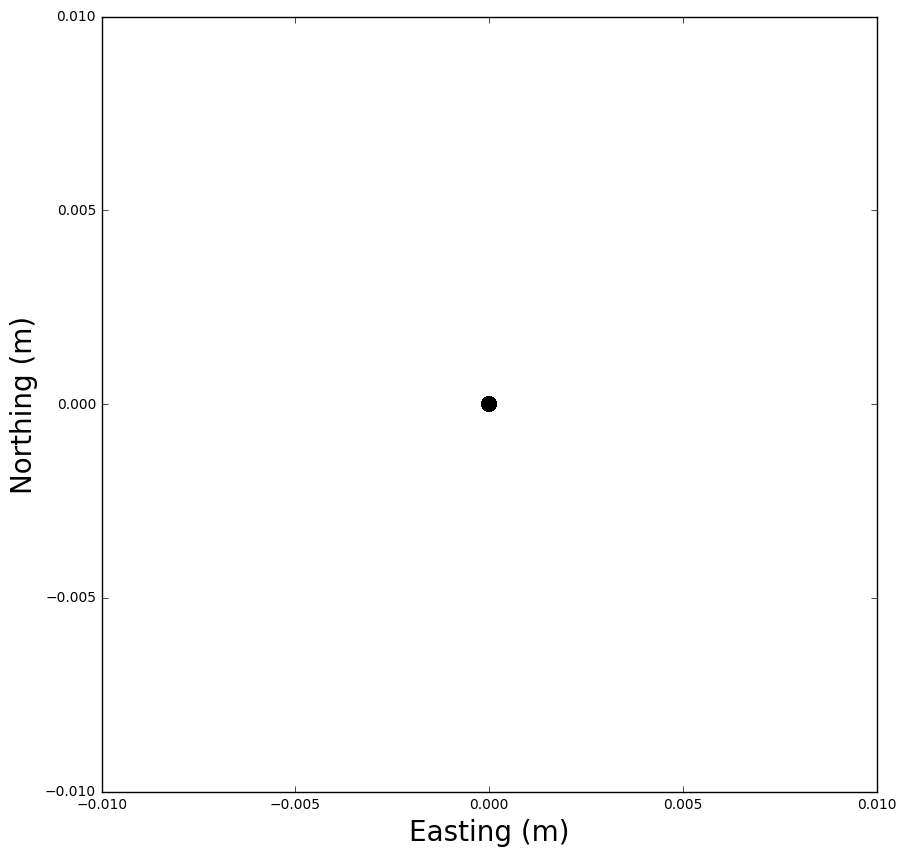

In [10]:
pl.figure(figsize=(10,10))
pl.scatter(krigdata[:,0], krigdata[:,1], c=krigdata[:,2], s=100, cmap='bone')
pl.xlabel("Easting (m)", fontsize=20)
pl.ylabel("Northing (m)", fontsize=20)

# Create and try to model the semi-variogram as we did in class
# https://github.com/fedhere/UInotebooks/blob/master/kriging/kriging_porosity.ipynb
# Explain what is going on